LSTM on past power data to predict power 1, 2 and 3 hours ahead

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
from scipy.stats import norm

# Import pytorch utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [4]:
x_train = pd.read_csv('windforecasts_wf1.csv', index_col='date')
y_train = pd.read_csv('train.csv')
# just consider the wind farm 1

In [5]:
# Brainstorm
# One metric for 24 hs and other for 48 hs ?
# 0) Check which wind farm to take before working on wf 1
# 0) calculating the MAE for AR-3  -> Baseline RMSE (Confidence interval?)
# 1) Making a prediction based on wp1 using LSTM
# 2) Metric for evaluating the model

In [6]:
y_train['date'] = pd.to_datetime(y_train.date, format= '%Y%m%d%H')
y_train.index = y_train['date'] 
y_train.drop('date', inplace = True, axis = 1)

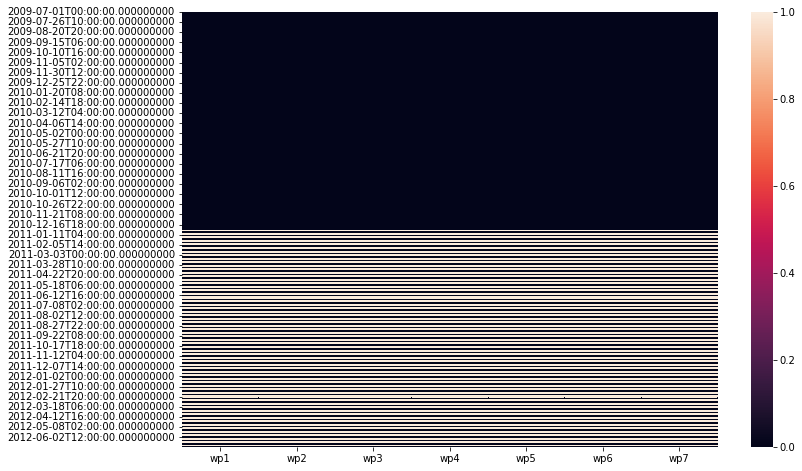

In [7]:
# Plot heatmap of missing data
ALL_TIME =  pd.DataFrame(index=pd.date_range(y_train.index[0],y_train.index[-1], freq='H')) 
plt.figure(figsize = (12,8))
sns.heatmap(y_train.join(ALL_TIME, how = 'outer').isna())  #['2011-06-01':'2011-06-04']

In [8]:
# Select forecast data set
x_train_update = x_train[x_train.hors<=12]
x_train_update.index = pd.to_datetime(x_train_update.index, format= '%Y%m%d%H')
x_train_update = x_train_update[:'2010-12-31 12']
x_train_update['time'] = x_train_update.index + pd.to_timedelta(x_train_update.hors,"H")

maxi=x_train_update[0:int(len(x_train_update)*0.8)+1].ws.max()
mini=x_train_update[0:int(len(x_train_update)*0.8)+1].ws.min()
x_train_update.ws=(x_train_update.ws-mini)/(maxi-mini)

# One hot encode the wind directions
wd_onehot = []

for i in range(len(x_train_update)):
  onehot = 12*[None]
  sector = np.floor(x_train_update.wd[i]/30)
  for s in range(12):
    if sector == s:
      onehot[s] = 1
    else:
      onehot[s] = 0
  wd_onehot.append(onehot)
  
  
x_train_sectors = pd.DataFrame(np.concatenate((np.reshape(x_train_update.ws.values,(len(x_train_update),1)),
                                              wd_onehot,
                                              np.cos(np.reshape(x_train_update.time.dt.hour.values,(len(x_train_update),1))*2*np.pi/24),
                                              np.sin(np.reshape(x_train_update.time.dt.hour.values,(len(x_train_update),1))*2*np.pi/24),
                                              np.cos(np.reshape(x_train_update.time.dt.dayofyear.values,(len(x_train_update),1))*2*np.pi/365),
                                              np.sin(np.reshape(x_train_update.time.dt.dayofyear.values,(len(x_train_update),1))*2*np.pi/365)),
                                            axis = 1),
            columns = 'ws s1 s2 s3 s4 s5 s6 s7 s8 s9 s10 s11 s12 time_day_cos time_day_sin time_year_cos time_year_sin'.split())
x_train_sectors.drop('s12',axis=1, inplace=True)

In [9]:
# Use only the power time series when continuous
complete_ts = y_train[:'2011-01-01 00'] # all the data without any gaps
input_generator = np.transpose(np.array([complete_ts.wp1]))
length = 20 # length of the time series, PARAMETER TO TUNE

In [10]:
# define validation and training set

batch_size = 8
# input_generator = np.transpose(np.array([y_train.wp1]))

# Note: TimeseriesGenerator end_index is including that index, not excluding it as it is the case in general in Python

training_set = TimeseriesGenerator(input_generator, input_generator, length=length, batch_size=batch_size, shuffle = False, start_index = 0 , end_index = int(len(complete_ts)*0.8)) # 80 percent
validation_set = TimeseriesGenerator(input_generator, input_generator, length=length, batch_size=batch_size, shuffle = False, start_index = int(len(complete_ts)*0.8)+1, end_index = len(complete_ts)-1)

In [11]:
print(f'The lenght of the validation set: {len(validation_set)}')
print(f'The lenght of the training set: {len(training_set)}')

The lenght of the validation set: 327
The lenght of the training set: 1316


**Creation of LSTM architecture**

In [12]:
class FFNN_LSTM(nn.Module):
    def __init__(self):
        super(FFNN_LSTM, self).__init__()
        # input_size – The number of expected features in the input x
        # hidden_size – The number of features in the hidden state h
        # batch_first = False >>> input prov (seq, batch, feature)

        self.lstm = nn.LSTM(input_size = 1, 
                  hidden_size = 512,
                     num_layers = 1,
                         batch_first = False)
        

        self.inputLay = nn.Linear(in_features = 16,
                               out_features = 512,
                               bias = True)
        
        self.hidden_layer = nn.Linear(in_features = 512,
                                      out_features = 512,
                                      bias = True)
        
        self.combined = nn.Linear(in_features= 512+512, 
                        out_features= 512,
                        bias = True) # should be false ?

        self.output_lay_expectation = nn.Linear(in_features= 512, 
                        out_features= 1,
                        bias = True) # should be false ?

        self.output_lay_variance = nn.Linear(in_features= 512, 
                out_features= 1,
                bias = True) # should be false ?

                 
    def forward(self, pow_seq, for_feat):
        #print(np.shape(x))
        x = torch.permute(pow_seq, (1,0,2) )  # permute batch with sequence 
        #print(np.shape(x))
        x, (h, c) = self.lstm(x)

        x = x[-1] # takes the last hidden state of LSTM
        #print(x)
        #print(np.shape(x))
        # Dense layer
        y = self.inputLay(for_feat)
        y = F.elu(y) # F = nn.Functional
        y = self.hidden_layer(y)
        y = F.elu(y)
        #print(y)
        #print(np.shape(y))
        z = torch.cat( (x,y), dim = 1 )
        #print(np.shape(z))
        z = self.combined(z)
        z = F.elu(z)
        z_expectation = self.output_lay_expectation(z)
        z_variance = torch.sigmoid(self.output_lay_variance(z))

        return z_expectation, z_variance
  
net = FFNN_LSTM()
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()

print(net)


##converting network to cuda-enabled
FFNN_LSTM(
  (lstm): LSTM(1, 512)
  (inputLay): Linear(in_features=16, out_features=512, bias=True)
  (hidden_layer): Linear(in_features=512, out_features=512, bias=True)
  (combined): Linear(in_features=1024, out_features=512, bias=True)
  (output_lay_expectation): Linear(in_features=512, out_features=1, bias=True)
  (output_lay_variance): Linear(in_features=512, out_features=1, bias=True)
)


In [13]:
myObj = FFNN_LSTM()
pow_seq = torch.Tensor(np.array([[[0.3],[0.4],[0.6]],[[0.4],[0.5],[0.7]]]))
for_feat = torch.Tensor([np.ones(16), np.ones(16)])
myObj(pow_seq , for_feat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


(tensor([[-0.0912],
         [-0.0916]], grad_fn=<AddmmBackward0>), tensor([[0.5003],
         [0.5003]], grad_fn=<SigmoidBackward0>))

**Training of the LSTM**

In [18]:
# Train loop 
criterion_MSE = nn.MSELoss() 
criterion_GNLLL = nn.GaussianNLLLoss()
optimizer = optim.Adam(net.parameters(),lr=5e-6) # , momentum=0.9

training_loss, validation_loss = [], []  # store loss for each epoch
best_loss = 0 # for early stopping
num_epochs = 500 # should be tuned

for i in range(num_epochs):
    boolean=0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.eval() # EVALUATION mode -> dont use regularization methods
        
    # For each sentence in validation set
    for j,(inputs, targets) in enumerate(validation_set):

        # Convert input to tensor
        inputs_pow = torch.Tensor(inputs)
        
        # ADD (length-1) hours and not length because the first forecast (index 0) is already for the next hour after the first observation.
        # The forecast in index (length-1) is then after the length first observations.
        # A -1 was added because the training set of forecast has one less value.
        
        inputs_pred = torch.Tensor(x_train_sectors.iloc[(j*batch_size+length-1+int(len(complete_ts)*0.8)+1-1):((j+1)*batch_size+length-1+int(len(complete_ts)*0.8)+1-1)].values)        
        # print('Inside training loop')
        # print(f'shape of input {np.shape(inputs)}')

        if len(inputs_pow) != batch_size:
          inputs_pred = inputs_pred[:len(inputs_pow)]

        # Convert target to tensor
        targets = torch.Tensor(targets)
        #print(targets)
        # print(f'shape of targets {np.shape(targets)}')
        
        #Convert targets and inputs to cuda
        if torch.cuda.is_available():
            inputs_pow = Variable(inputs_pow.cuda())
            inputs_pred = Variable(inputs_pred.cuda())
            targets = Variable(targets.cuda())
        
        # Evaluate the model
        outputs = net(inputs_pow,inputs_pred) 

        # print(f'shape of outputs {np.shape(outputs)}')
        #print(outputs)
        # Compute loss


        loss_optimized =  criterion_GNLLL(outputs[0],targets,outputs[1]) 
        MSE = criterion_MSE(outputs[0],targets)

        if torch.cuda.is_available():
          epoch_validation_loss += MSE.cpu().detach().numpy()
        else:
          epoch_validation_loss += MSE.detach().numpy() # suma el loss de cada batch, luego se reinicia para proxima epoch
    
    
    net.train()

    for j,(inputs, targets) in enumerate(training_set):

            # Convert input to tensor
            inputs_pred = torch.Tensor(x_train_sectors.iloc[(j*batch_size+length-1):((j+1)*batch_size+length-1)].values)
            inputs_pow = torch.Tensor(inputs)
            # print('Inside training loop')
            # print(f'shape of input {np.shape(inputs)}')

            # Convert target to tensor
            targets = torch.Tensor(targets)
            #print(targets)
            # print(f'shape of targets {np.shape(targets)}')

            if len(inputs_pow) != batch_size:
              inputs_pred = inputs_pred[:len(inputs_pow)]
            
            #Convert targets and inputs to cuda
            if torch.cuda.is_available():
                inputs_pow = Variable(inputs_pow.cuda())
                inputs_pred = Variable(inputs_pred.cuda())
                targets = Variable(targets.cuda())
            
            # Evaluate the model
            outputs = net(inputs_pow,inputs_pred)      
            # print(f'shape of outputs {np.shape(outputs)}')
            #print(outputs)
            # Compute loss
            loss_optimized =  criterion_GNLLL(outputs[0],targets,outputs[1]) 
            MSE = criterion_MSE(outputs[0],targets)

            optimizer.zero_grad() # zero the gradients
            loss_optimized.backward()       # calculate gradients for current step
            optimizer.step()      # update the weights 

            if torch.cuda.is_available():
              epoch_training_loss += MSE.cpu().detach().numpy()
            else:
              epoch_training_loss += MSE.detach().numpy()

    # Save loss for plot
    training_loss.append(np.sqrt(epoch_training_loss/(len(training_set)-1)))
    validation_loss.append(np.sqrt(epoch_validation_loss/(len(validation_set)-1)))       
    print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


Epoch 0, training loss: 0.06445897464911801, validation loss: 0.06692243253516167
Epoch 1, training loss: 0.0644559778065298, validation loss: 0.06694600403650006
Epoch 2, training loss: 0.06445413120998585, validation loss: 0.06694442379812567
Epoch 3, training loss: 0.0644519410586468, validation loss: 0.0669403875612639
Epoch 4, training loss: 0.06444963024050876, validation loss: 0.06693396840019755
Epoch 5, training loss: 0.06444740046067414, validation loss: 0.06692749114104936
Epoch 6, training loss: 0.06444533992874854, validation loss: 0.06692265600351957
Epoch 7, training loss: 0.0644433986868028, validation loss: 0.06691999908645961
Epoch 8, training loss: 0.06444151130915175, validation loss: 0.06691938410744026
Epoch 9, training loss: 0.06443964161588876, validation loss: 0.06692036140792106
Epoch 10, training loss: 0.06443775676889024, validation loss: 0.0669222709747415
Epoch 11, training loss: 0.06443583909081646, validation loss: 0.06692435591316392
Epoch 12, training 

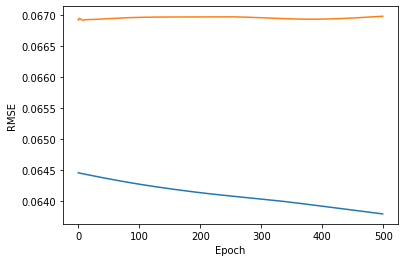

In [19]:
# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, epoch, validation_loss)
plt.xlabel('Epoch'), plt.ylabel('RMSE')
plt.show()

**Evaluation of LSTM 1 to 6 hours ahead, on validation set**

In [16]:
# Define the validation set as one sequence
validation_power = input_generator[int(len(input_generator)*0.8)+1 : int(len(input_generator))-1]

In [17]:
# Define slices of 24h inputs and corresponding targets 1, 2 and 3 hours ahead
p_inputs = []
p_targets1h = []
p_targets2h = []
p_targets3h = []
p_targets4h = []
p_targets5h = []
p_targets6h = []
for i in range(len(validation_power)-(length+2)):
  p_inputs.append(validation_power[i:i+length])
  p_targets1h.append(validation_power[i+length])
  p_targets2h.append(validation_power[i+length+1])
  p_targets3h.append(validation_power[i+length+2])
  p_targets4h.append(validation_power[i+length+3])
  p_targets5h.append(validation_power[i+length+4])
  p_targets6h.append(validation_power[i+length+5])

IndexError: ignored

In [ ]:
# Forecasting 1, 2 and 3 hours ahead

# Back on CPU
net.to('cpu')

# Store predictions and errors
pred_1h = []
err_1h = []
pred_2h = []
err_2h = []
pred_3h = []
err_3h = []
pred_4h = []
err_4h = []
pred_5h = []
err_5h = []
pred_6h = []
err_6h = []

# Loop over the sequences of valid data
for seq in range(len(p_inputs)):

    # Define past value for the 1h forecast
    past = p_inputs[seq]
    
    # Take output for the past sequence
    pred_1h.append(net(torch.Tensor([past])).item())
    err_1h.append(pred_1h[-1]-p_targets1h[seq][0])

    # Repeat with prediction 2 hours ahead actualizing the past values
    past = np.append(past,[[pred_1h[-1]]],0)
    pred_2h.append(net(torch.Tensor([past])).item())
    err_2h.append(pred_2h[-1]-p_targets2h[seq][0])

    # Repeat with prediction 3 hours ahead
    past = np.append(past,[[pred_2h[-1]]],0)
    pred_3h.append(net(torch.Tensor([past])).item())
    err_3h.append(pred_3h[-1]-p_targets3h[seq][0])

    # Repeat with prediction 4 hours ahead
    past = np.append(past,[[pred_3h[-1]]],0)
    pred_4h.append(net(torch.Tensor([past])).item())
    err_4h.append(pred_4h[-1]-p_targets4h[seq][0])

    # Repeat with prediction 5 hours ahead
    past = np.append(past,[[pred_4h[-1]]],0)
    pred_5h.append(net(torch.Tensor([past])).item())
    err_5h.append(pred_5h[-1]-p_targets5h[seq][0])

    # Repeat with prediction 6 hours ahead
    past = np.append(past,[[pred_5h[-1]]],0)
    pred_6h.append(net(torch.Tensor([past])).item())
    err_6h.append(pred_6h[-1]-p_targets6h[seq][0])

    if seq % 100 == 0:
      print(f'step {seq+1}, RMSE 1h: {np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))}, RMSE 2h: {np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))}, RMSE 3h: {np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))}, RMSE 4h: {np.sqrt(stat.mean(err_4h[n]**2 for n in range(len(err_4h))))}, RMSE 5h: {np.sqrt(stat.mean(err_5h[n]**2 for n in range(len(err_5h))))}, RMSE 6h: {np.sqrt(stat.mean(err_6h[n]**2 for n in range(len(err_6h))))}')

In [ ]:
# Estimation of confidence intervals:
RMSE_1h = np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))
RMSE_2h = np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))
RMSE_3h = np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))
CI_1h = [norm.ppf(0.025)*RMSE_1h,norm.ppf(0.975)*RMSE_1h]
CI_2h = [norm.ppf(0.025)*RMSE_2h,norm.ppf(0.975)*RMSE_2h]
CI_3h = [norm.ppf(0.025)*RMSE_3h,norm.ppf(0.975)*RMSE_3h]
print(f'Confidence interval 1h: {CI_1h}')
print(f'Confidence interval 2h: {CI_2h}')
print(f'Confidence interval 3h: {CI_3h}')